In [5]:
#Importing the necessary libraries
import os
import math
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import face_recognition
import imageio
import pickle
import shutil
import seaborn as sns
from distutils.dir_util import copy_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import csv
import datetime

In [2]:
# Directories
main_folder = "Headshots/"
training_folder = "Processed_Headshots_Training/"
validation_folder = "Processed_Headshots_Validation/"
testing_folder = "Processed_Headshots_Testing/"

# Ensure output directories exist
for folder in [training_folder, validation_folder, testing_folder]:
    os.makedirs(folder, exist_ok=True)

current_id = 0
label_ids = {}

# Function to split the path into parts and rebuild it
def rebuild_path(original_path, source_folder, target_folder):
    parts = os.path.relpath(original_path, source_folder).split(os.sep)
    return os.path.join(target_folder, *parts)

# Iterate over the main folder and its subfolders
for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            # Load image path
            input_image_path = os.path.join(root, file)

            try:
                # Use face_recognition to find face locations
                image = face_recognition.load_image_file(input_image_path)
                face_locations = face_recognition.face_locations(image)

                if face_locations:
                    # Extract the first detected face location
                    top, right, bottom, left = face_locations[0]

                    # Crop the detected face region
                    detected_face = image[top:bottom, left:right]

                    # Resize the detected face to 224x224 pixels
                    resized_face = cv2.resize(detected_face, (224, 224), interpolation=cv2.INTER_AREA)

                    # Determine output folder based on split
                    split_value = hash(file) % 10
                    if split_value < 7:
                        output_folder_path = training_folder
                    elif split_value < 9:
                        output_folder_path = validation_folder
                    else:
                        output_folder_path = testing_folder

                    # Rebuild output path to maintain folder structure
                    output_image_path = rebuild_path(input_image_path, main_folder, output_folder_path)

                    # Ensure output directory exists
                    os.makedirs(os.path.dirname(output_image_path), exist_ok=True)

                    # Save the resized detected face
                    cv2.imwrite(output_image_path, cv2.cvtColor(resized_face, cv2.COLOR_RGB2BGR))

                    # Get label name
                    label = os.path.basename(root).replace(" ", ".").lower()

                    # Add the label (key) and its number (value)
                    if label not in label_ids:
                        label_ids[label] = current_id
                        current_id += 1
                else:
                    print(f"No face detected in {input_image_path}")
            except Exception as e:
                print(f"An error occurred for {input_image_path}: {e}")

# Print label IDs
print(label_ids)


{'rishab_naik': 0, 'unknown_face': 1, 'varun_rao': 2, 'vijay_raj': 3, 'vinyas_shetty': 4}


In [2]:

# Image augmentation parameters
training_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Directories for the original datasets
training_dir = './Processed_Headshots_Training'
validation_dir = './Processed_Headshots_Validation'

# Directories to save augmented images
output_training_dir = './Augmented_Processed_Headshots_Training'
output_validation_dir = './Augmented_Processed_Headshots_Validation'

# Ensure output directories exist
os.makedirs(output_training_dir, exist_ok=True)
os.makedirs(output_validation_dir, exist_ok=True)

# Setup generators
training_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    save_to_dir=output_training_dir,
    save_prefix='augmented_',
    save_format='png'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    save_to_dir=output_validation_dir,
    save_prefix='augmented_',
    save_format='png'
)

Found 71 images belonging to 5 classes.
Found 21 images belonging to 5 classes.


In [3]:
#Getting the number of classes
training_generator.class_indices.values()
# dict_values([0, 1, 2])
NO_CLASSES = len(training_generator.class_indices.values())

In [6]:
#VGG 16 cnn model instantiation 
from keras_vggface.vggface import VGGFace

base_model = VGGFace(include_top=True,model='vgg16',input_shape=(224, 224, 3))
base_model.summary()

print(len(base_model.layers))
# 26 layers in the original VGG-Face


Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [7]:
# 19 layers after excluding the last few layers that are fully connected
base_model = VGGFace(include_top=False,model='vgg16',input_shape=(224, 224, 3))
base_model.summary()
print(len(base_model.layers))


Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [9]:
# Assuming base_model is defined

x = base_model.output

# Apply Global Average Pooling
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# final layer with softmax activation
preds = Dense(NO_CLASSES, activation='softmax')(x)


In [10]:
# create a new model with the base model's original input and the 
# new model's output
model = Model(inputs = base_model.input, outputs = preds)
model.summary()

# don't train the first 19 layers - 0..18
for layer in model.layers[:19]:
    layer.trainable = False

# train the rest of the layers - 19 onwards
for layer in model.layers[19:]:
    layer.trainable = True


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [11]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [12]:
history=model.fit(training_generator,batch_size = 1,verbose = 1,epochs = 15,validation_data=validation_generator)


Epoch 1/15
3/3 [==============================] - 17s 7s/step - loss: 1.6070 - accuracy: 0.2676 - val_loss: 1.5632 - val_accuracy: 0.4286
Epoch 2/15
3/3 [==============================] - 16s 5s/step - loss: 1.5191 - accuracy: 0.4930 - val_loss: 1.4554 - val_accuracy: 0.5238
Epoch 3/15
3/3 [==============================] - 16s 5s/step - loss: 1.3919 - accuracy: 0.5775 - val_loss: 1.2812 - val_accuracy: 0.3810
Epoch 4/15
3/3 [==============================] - 17s 5s/step - loss: 1.1608 - accuracy: 0.5493 - val_loss: 1.0244 - val_accuracy: 0.9048
Epoch 5/15
3/3 [==============================] - 16s 5s/step - loss: 0.9051 - accuracy: 0.8732 - val_loss: 0.7299 - val_accuracy: 0.8571
Epoch 6/15
3/3 [==============================] - 16s 5s/step - loss: 0.6365 - accuracy: 0.8873 - val_loss: 0.5306 - val_accuracy: 1.0000
Epoch 7/15
3/3 [==============================] - 15s 7s/step - loss: 0.4743 - accuracy: 0.8873 - val_loss: 0.3684 - val_accuracy: 0.9524
Epoch 8/15
3/3 [==================

In [13]:
# creates a HDF5 file
model.save('transfer_learning_trained' +'_face_cnn_model.h5')


In [14]:
# Access training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss=history.history['loss']
validation_loss=history.history['val_loss']
# Print or use the accuracy values as needed
print("Training Accuracy:",(training_accuracy[-1]*100))
print("Validation Accuracy:",(validation_accuracy[-1]*100))


Training Accuracy: 98.591548204422
Validation Accuracy: 100.0


In [5]:
import pickle

class_dictionary = training_generator.class_indices
class_dictionary = {value: key for key, value in class_dictionary.items()}
print(class_dictionary)



{0: 'Rishab_Naik', 1: 'Unknown_Face', 2: 'Varun_Rao', 3: 'Vijay_Raj', 4: 'Vinyas_Shetty'}


In [6]:
# save the class dictionary to pickle
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, 'wb') as f: pickle.dump(class_dictionary, f)

In [7]:
from PIL import Image
from tensorflow.keras.preprocessing import image
from keras_vggface import utils
class_dictionary={0: 'Rishab_Naik', 1: 'Unknown_Face', 2: 'Varun_Rao', 3: 'Vijay_Raj', 4: 'Vinyas_Shetty'}
class_list = [value for _, value in class_dictionary.items()]

In [8]:
label_ids={'rishab_naik': 0, 'unknown_face': 1, 'varun_rao': 2, 'vijay_raj': 3, 'vinyas_shetty': 4}

1/1 [==============================] - 0s 206ms/step


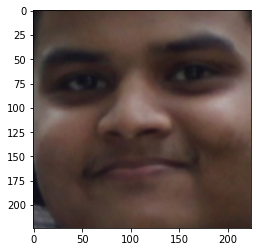

[[1. 0. 0. 0. 0.]]
0
Predicted face: Rishab_Naik

1/1 [==============================] - 0s 206ms/step


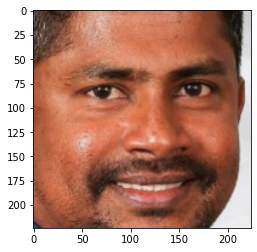

[[0. 1. 0. 0. 0.]]
1
Predicted face: Unknown_Face

1/1 [==============================] - 0s 223ms/step


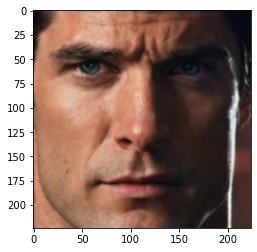

[[0. 1. 0. 0. 0.]]
1
Predicted face: Unknown_Face

1/1 [==============================] - 0s 204ms/step


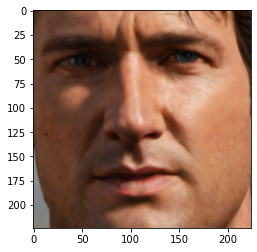

[[0. 1. 0. 0. 0.]]
1
Predicted face: Unknown_Face

1/1 [==============================] - 0s 222ms/step


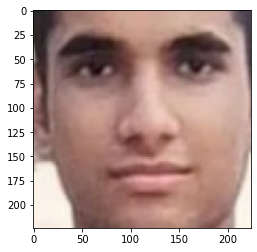

[[0. 0. 1. 0. 0.]]
2
Predicted face: Varun_Rao

1/1 [==============================] - 0s 227ms/step


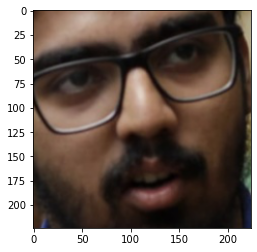

[[0. 1. 0. 0. 0.]]
1
Predicted face: Unknown_Face

Ground Truth Labels: [0, 1, 1, 1, 2, 4]
Predicted Labels: [0, 1, 1, 1, 2, 1]


In [6]:
#Testing
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import load_model

# Define the image dimensions
image_width, image_height = 224, 224
y_test = []
pred12 = []

# Path to the testing folder
testing_folder = "Processed_Headshots_Testing/"

# Load the trained model outside the loop
model = load_model('transfer_learning_trained_face_cnn_model.h5')

# Function to get label index from folder name
def get_label_index(folder_name):
    # Convert folder name to lowercase and remove spaces
    label = folder_name.replace(" ", ".").lower()
    # Check if label exists in label_ids dictionary
    if label in label_ids:
        return label_ids[label]
    else:
        return None

# Iterate over the testing folder and its subfolders
for root, dirs, files in os.walk(testing_folder):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            # Load image path
            test_image_filename = os.path.join(root, file)

            # Load the image using face_recognition
            imgtest = face_recognition.load_image_file(test_image_filename)
            image_array = np.array(imgtest, "uint8")

            # Get face locations in the image
            face_locations = face_recognition.face_locations(imgtest)

            for face_location in face_locations:
                # Extract face coordinates
                top, right, bottom, left = face_location

                # Resize the detected face to 224x224
                roi = image_array[top:bottom, left:right]
                resized_image = cv2.resize(roi, (image_width, image_height))

                # Prepare the image for prediction
                x = image.img_to_array(resized_image)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                
                # Prepare the image for prediction
                x = image.img_to_array(resized_image)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                
                # Making prediction
                # Load the trained model
                model = load_model('transfer_learning_trained_face_cnn_model.h5')
                predicted_prob = model.predict(x)
                plt.imshow(resized_image)
                plt.show()
                print(predicted_prob)
                print(predicted_prob[0].argmax())
                print("Predicted face: " + class_list[predicted_prob[0].argmax()])
                print("============================\n")
                
                 # Get label index from folder name
                label_index = get_label_index(os.path.basename(root))

                # Store ground truth label index
                y_test.append(label_index)

                # Store predicted value
                pred12.append(predicted_prob[0].argmax())

# Print results
print("Ground Truth Labels:", y_test)
print("Predicted Labels:", pred12)

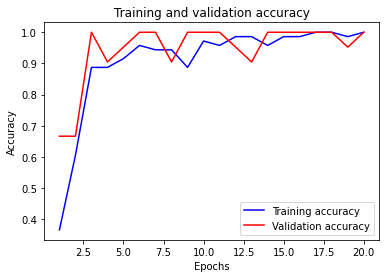

In [19]:
#Learning curve of Training accuracy and Validation accuracy
epochs = range(1,len(training_accuracy)+1)
plt.plot(epochs, training_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

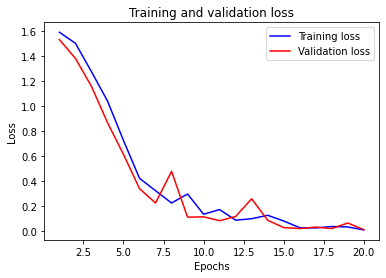

In [20]:
#Learning curve of Training and validation loss
epochs=range(1,len(training_accuracy)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [30]:
#Classification report
print(classification_report(pred12, y_test,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       0.00      1.00      0.00         0

    accuracy                           0.86         7
   macro avg       0.80      0.95      0.77         7
weighted avg       1.00      0.86      0.92         7



In [31]:
#confusion matrix
cm = confusion_matrix(pred12,y_test)
cm

array([[1, 0, 0, 0, 0],
       [0, 3, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]], dtype=int64)

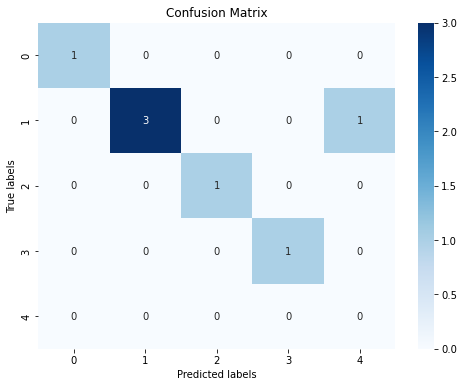

In [32]:
#Heatmap for the confusion matrix
labels = [0, 1, 2, 3, 4]
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Function to get USN from the student database CSV file based on the predicted class label
def get_usn_from_label(label):
    with open('Student_Database.csv', mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if 'NAME' in row and row['NAME'] == label:
                return row.get('USN', None)
    return None
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('transfer_learning_trained_face_cnn_model.h5')

# Load the labels
with open("face-labels.pickle", 'rb') as f:
    og_labels = pickle.load(f)
    # Decode byte strings using UTF-8 and remove 'b' prefix
    labels = {key: value.lstrip('b') for key, value in og_labels.items()}
    print(labels)

# Webcam settings
screen_width = 1280
screen_height = 720
image_width = 224
image_height = 224

# Open default webcam
stream = cv2.VideoCapture(0)

# Set to store processed labels
processed_labels = set()

# Open Attendance CSV file in append mode
with open('Attendance1.csv', mode='a', newline='') as file:
    writer = csv.writer(file)

    while True:
        # Capture frame-by-frame
        grabbed, frame = stream.read()
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Find all face locations in the frame
        face_locations = face_recognition.face_locations(rgb)

        for (top, right, bottom, left) in face_locations:
            # Draw a rectangle around the face
            color = (255, 0, 0)  # BGR
            stroke = 2
            cv2.rectangle(frame, (left, top), (right, bottom), color, stroke)

            # Resize and preprocess the image
            roi_rgb = rgb[top:bottom, left:right]
            resized_image = cv2.resize(roi_rgb, (image_width, image_height))
            img = np.expand_dims(resized_image, axis=0)  # Add batch dimension
            img = img.astype('float32') / 255.0

            # Predict the image
            predicted_prob = model.predict(img)

            # Display the label
            font = cv2.FONT_HERSHEY_SIMPLEX
            name = labels[predicted_prob[0].argmax()]
            color = (255, 0, 255)
            stroke = 2
            cv2.putText(frame, f'({name})', (left, top - 8),
                        font, 1, color, stroke, cv2.LINE_AA)

            # Get USN from student database
            usn = get_usn_from_label(name)
            if usn is not None and name not in processed_labels:
                # Get current time and date
                current_time = datetime.datetime.now().strftime('%H:%M:%S')
                current_date = datetime.datetime.now().strftime('%Y-%m-%d')

                # Write data to Attendance CSV file
                writer.writerow([name, usn, current_time, current_date])
                # Add the label to the set of processed labels
                processed_labels.add(name)

        # Display the frame
        cv2.imshow("Image", frame)

        # Check for the 'q' key to break out of the loop
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

# Release the stream and close all OpenCV windows
stream.release()
cv2.destroyAllWindows()


{0: 'Rishab_Naik', 1: 'Unknown_Face', 2: 'Varun_Rao', 3: 'Vijay_Raj', 4: 'Vinyas_Shetty'}
1/1 [==============================] - 0s 113ms/step
